In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import datetime
import scipy as sp
import scipy.fftpack
from scipy.fft import fftshift

In [2]:
# Einlesen der wind .csv Datei
# Timestamp zu Datetime
# Datetime wird zu Index

filename_wind = 'environment/wind/lidar/lidar_2019-08-15.csv'
df_wind = pd.read_csv(filename_wind, delimiter=',', decimal='.')
df_wind['epoch'] = df_wind['epoch'].astype(int)
df_wind['epoch'] = pd.to_datetime(df_wind['epoch'], unit='s')
df_wind = df_wind.set_index(pd.DatetimeIndex(df_wind['epoch'].values))
df_wind.head()

,epoch,wind_speed_0,wind_dir_0,wind_dir_0_corr,height_0,wind_speed_1,wind_dir_1,wind_dir_1_corr,height_1,wind_speed_2,...,height_8,wind_speed_9,wind_dir_9,wind_dir_9_corr,height_9,wind_speed_10,wind_dir_10,wind_dir_10_corr,height_10,heading
2019-08-14 22:00:00,2019-08-14 22:00:00,9.5,188.7,185.78,88.01,10.0,189.7,186.78,98.01,10.2,...,133.01,10.5,193.4,190.48,138.01,10.5,193.2,190.28,143.01,357.08
2019-08-14 22:00:01,2019-08-14 22:00:01,9.5,188.7,185.80,88.01,10.0,189.7,186.80,98.01,10.2,...,133.01,10.5,193.4,190.50,138.01,10.5,193.2,190.30,143.01,357.10
2019-08-14 22:00:02,2019-08-14 22:00:02,9.5,185.1,182.20,88.01,9.9,185.4,182.50,98.01,10.1,...,133.01,10.4,191.6,188.70,138.01,10.4,191.6,188.70,143.01,357.10
2019-08-14 22:00:03,2019-08-14 22:00:03,9.5,185.1,182.11,88.01,9.9,185.4,182.41,98.01,10.1,...,133.01,10.4,191.6,188.61,138.01,10.4,191.6,188.61,143.01,357.01
2019-08-14 22:00:04,2019-08-14 22:00:04,9.5,185.1,182.14,88.01,9.9,185.4,182.44,98.01,10.1,...,133.01,10.4,191.6,188.64,138.01,10.4,191.6,188.64,143.01,357.04


In [3]:
filename_wave = 'environment/waves/wmb-sued/wmb-sued_2019-08-15.csv'
df_wave = pd.read_csv(filename_wave, delimiter=',', decimal='.')
df_wave['epoch'] = df_wave['epoch'].astype(int)
df_wave['epoch'] = pd.to_datetime(df_wave['epoch'], unit='s')
df_wave = df_wave.set_index(pd.DatetimeIndex(df_wave['epoch'].values))
df_wave.head()

,epoch,Tp,Dirp,Sprp,Tz,Hm0,TI,T1,Tc,Tdw2,...,Hmax,Tmax,H(1/10),T(1/10),H(1/3),T(1/3),Hav,Tav,Eps,Waves
2019-08-14 22:00:00,2019-08-14 22:00:00,5.00,265.8,39.2,3.922,1.23,4.98,4.17,3.07,4.42,...,2.25,4.15,1.4543,4.87,1.1811,4.87,76.03,4.17,0.600,431.0
2019-08-14 22:30:00,2019-08-14 22:30:00,5.56,263.0,32.3,3.960,1.28,4.99,4.20,3.09,4.44,...,1.90,4.55,1.3992,4.92,1.1233,4.85,71.41,4.06,0.578,443.0
2019-08-14 23:00:00,2019-08-14 23:00:00,5.56,260.2,37.0,4.040,1.31,5.06,4.29,3.13,4.53,...,1.90,3.93,1.4494,5.02,1.1588,4.93,74.39,4.15,0.611,433.0
2019-08-14 23:30:00,2019-08-14 23:30:00,5.56,255.9,40.8,3.922,1.28,5.02,4.17,3.05,4.43,...,3.62,48.98,1.4444,6.07,1.1418,5.19,74.28,4.14,0.594,433.0
2019-08-15 00:00:00,2019-08-15 00:00:00,5.56,257.3,35.0,4.040,1.32,10.00,4.46,2.99,5.50,...,1.91,4.46,1.4920,4.80,1.1991,4.86,75.15,4.00,0.526,449.0


77424


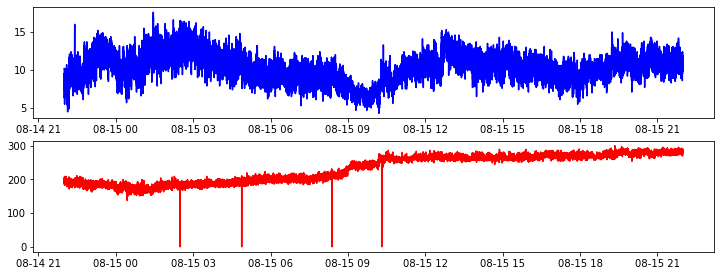

In [40]:
#

wind_speed_avg = df_wind.wind_speed_2.ewm(span=250,adjust=False).mean()
wind_direction_avg = df_wind.wind_dir_2.ewm(span=100,adjust=False).mean()
print(len(df_wind))
plt.figure(figsize=(12.2, 4.5))
plt.subplot(211)
plt.plot(df_wind.index, df_wind["wind_speed_2"], label='Windspeed_2', color='blue')
plt.subplot(212)
plt.plot(df_wind.index, df_wind["wind_dir_2"], label='Winddirection_2', color='red')

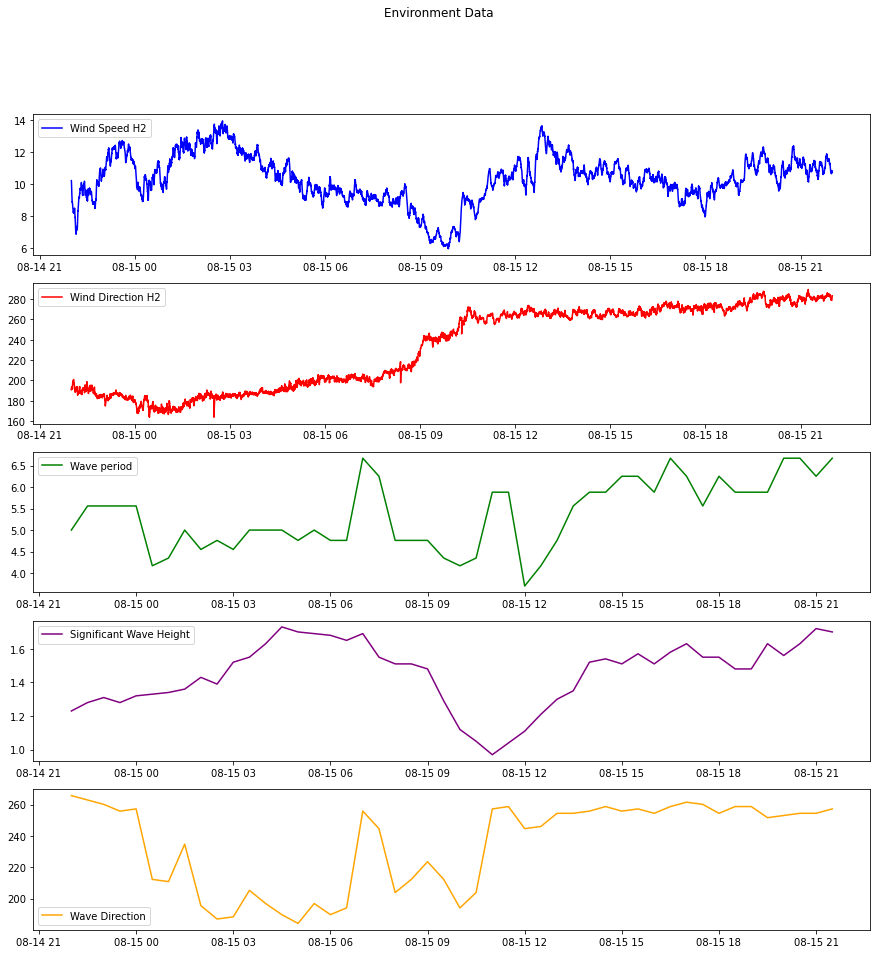

In [58]:
#plotting 
f, axs = plt.subplots(5,figsize=(15,15))
f.suptitle('Environment Data')
axs[0].plot(df_wind.index, wind_speed_avg, label='Wind Speed H2', color='blue')
axs[0].legend(loc="upper left")
axs[1].plot(df_wind.index, wind_direction_avg, label='Wind Direction H2', color='red')
axs[1].legend(loc="upper left")
axs[2].plot(df_wave.index, df_wave["Tp"], label='Wave period', color='green')
axs[2].legend(loc="upper left")
axs[3].plot(df_wave.index, df_wave["Hm0"], label='Significant Wave Height', color='purple')
axs[3].legend(loc="upper left")
axs[4].plot(df_wave.index, df_wave["Dirp"], label='Wave Direction', color='orange')
axs[4].legend(loc="lower left")


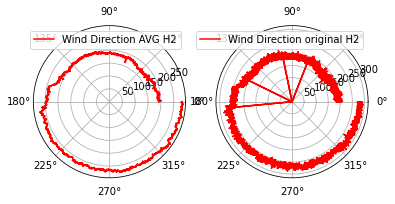

In [61]:
#TEST


#Wind direction polar axes plot
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))
x = np.linspace(0, 2 * np.pi, 77424)
ax1.plot(x, wind_direction_avg, label='Wind Direction AVG H2', color='red')
ax1.legend(loc="best")
ax2.plot(x, df_wind["wind_dir_2"], label='Wind Direction original H2', color='red')
ax2.legend(loc="best")


Wave Direction original H2


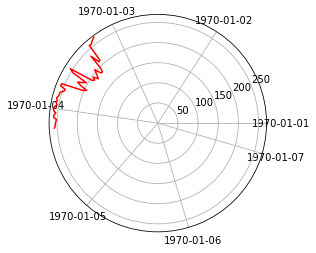

In [69]:
#wave direction polar axes plot
fig, (ax1) = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
x = np.linspace(0, 2 * np.pi, 48)
ax1.plot(df_wave.index, df_wave["Dirp"], label='Wind Direction original H2', color='red')
#ax1.legend(loc="upper right")
print("Wave Direction original H2")